## 3-1. この節の目標
この節では主に教師ありの場合、すなわち$q_\theta(y|{\bf x})$のモデルとしてニューラルネットワークを導入してみましょう。初めに言ってしまうと、ニューラルネットワークとは何のことはない

$$
{\bf x} 
\overset{\text{linear}}{\to}
\cdot
\overset{\text{non-linear}}{\to}
{\bf h}_1
\overset{\text{linear}}{\to}
\cdot
\overset{\text{non-linear}}{\to}
{\bf h}_2
\to \dots
\to
{\bf h}_L
$$

という関数のことであり、多くの場合、**非線形変換は固定**し、**線形変換のパラメータを変化**させ、出力 ${\bf h}_L$ が望む値になるようにする、というものです。以下では再びアヤメデータを使って、簡単なニューラルネットワークの構成から、これを用いた分類までを [PyTorch](https://pytorch.org) で実装した例をお見せします。その後、続く小節でそれぞれの部分について説明したいと思います。まず必要なライブラリをインポートします：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_iris

### アヤメデータを用いた教師あり学習
アヤメデータは以下で読み込めるのでした：

In [2]:
iris = load_iris() # アヤメデータ読み込み

このオブジェクトには色々なデータが入っています。特に今回は
- `iris.data`: 入力 ${\bf x}_n$ のデータ
- `iris.target`: 望む答え $y_n$ のデータ

を使います：

In [3]:
iris.data.shape, iris.target.shape # 150個の4次元データ, 150個の1次元データ

((150, 4), (150,))

#### Data Loader
まず、データをいい感じに読み込んでくれるサブルーチンを定義します：

In [4]:
def return_iris_loader(X, Y, bs=10):
    data = torch.utils.data.TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
    return torch.utils.data.DataLoader(data, batch_size=bs, shuffle=True)  

これは

In [5]:
X_train, Y_train = iris.data[::2], iris.target[::2] # 偶数番目のデータ
training_data_loader = return_iris_loader(X_train, Y_train, bs=10)

としておくと、自動で「シャッフル $\to$ `bs`個取る」を実装してくれて便利です：

In [6]:
iter(return_iris_loader(X_train, Y_train, bs=10)).next()

[tensor([[6.3000, 2.5000, 4.9000, 1.5000],
         [5.9000, 3.2000, 4.8000, 1.8000],
         [5.0000, 3.6000, 1.4000, 0.2000],
         [6.4000, 2.9000, 4.3000, 1.3000],
         [7.4000, 2.8000, 6.1000, 1.9000],
         [6.2000, 2.2000, 4.5000, 1.5000],
         [6.4000, 2.8000, 5.6000, 2.2000],
         [5.8000, 2.7000, 3.9000, 1.2000],
         [6.1000, 2.6000, 5.6000, 1.4000],
         [7.0000, 3.2000, 4.7000, 1.4000]], dtype=torch.float64),
 tensor([1, 1, 0, 1, 2, 1, 2, 1, 2, 1])]

#### ニューラルネットワーク
ニューラルネットワークはクラスとして実装します。以下では

$$
{\bf x} (4D) \to {\bf h}_1(10D) \to {\bf h}_2(3D)
$$

を設計しています。

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class MyNN(nn.Module):
    def __init__(self):
        H = 10
        super(MyNN, self).__init__()
        self.l1 = nn.Linear(4, H)
        self.l2 = nn.Linear(H, 3)
    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.softmax(self.l2(h), dim=1) # dim=axis
        return h

ここで`__call__`にある`F.softmax`はソフトマックス関数と呼ばれるもので、

$$
\text{softmax}({\bf u}) = \frac{1}{\sum_{i} e^{u^i}} (e^{u^1}, e^{u^2}, \dots, e^{u^{dim}})
$$

と定義されます。また、`F.relu`は

$$
\text{relu}({\bf u}) = (\max\{0, u^1\}, \max\{0, u^2\}, \dots, \max\{0, u^{dim}\})
$$

という関数です。実際にものを作るには、上の宣言後

In [18]:
model = MyNN()

#### 学習の設定
どんな目的関数を、どのように小さくするかの設定

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

`criterion = torch.nn.CrossEntropyLoss()`はクロスエントロピーと呼ばれる関数を表します。ここでは分類数が3なので、${\bf y}_{model} \in [0,1]^3, y \in \{0,1,2\}$ として

$$
criterion({\bf y}_{model}, y) = - \log ({\bf y}_{model})^{y\text{-th component}}
$$

を表します。`torch.optim.SGD`は勾配更新（後述）のためのオブジェクトです。

#### 学習実行
`for` ループで少しずつ改善させます：

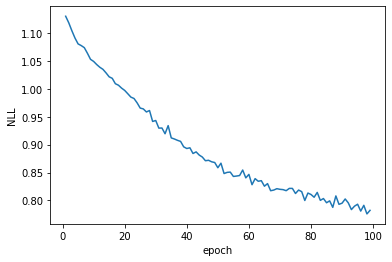

In [20]:
epochs=np.arange(1, 100)
nlls = []

for epoch in epochs:
    nll = []
    for minibatch_index, (x, y) in enumerate(training_data_loader):
        x, y = torch.autograd.Variable(x).float(), torch.autograd.Variable(y)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        nll.append(loss.data.numpy().tolist())
        loss.backward()
        optimizer.step()
    nlls.append(np.average(nll))

plt.xlabel("epoch"); plt.ylabel("NLL")
plt.plot(epochs, nlls);plt.show()
    

#### 新しいデータでテスト

In [21]:
X_test, Y_test = iris.data[1::2], iris.target[1::2]
test_iter=iter(return_iris_loader(X_test, Y_test, bs=1))

answer: tensor([0]) prediction: 0


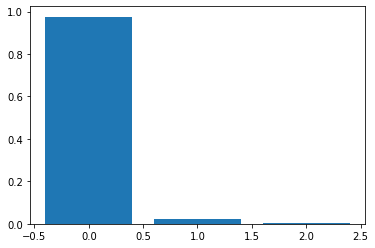

In [26]:
x, y = test_iter.next()
x = torch.autograd.Variable(x).float()
y_pred = model(x).data.numpy()
print('answer:', y, 'prediction:', np.argmax(y_pred))
plt.bar(np.arange(3), y_pred[0]); plt.show()

正しく分類できているのがわかります。